In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
import re
import pandas as pd
import datetime
import pdb
from threading import Thread
import time
import pdb
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Inline so we can draw it in Jupyter
%matplotlib inline

In [2]:
def get_distance_from_center(txt):
    if ("מ'" in txt):
        # https://stackoverflow.com/questions/4289331/how-to-extract-numbers-from-a-string-in-python # 
        distance_from_center = float(re.findall("\d+",txt)[0])
        return distance_from_center/1000
    elif ("." in txt):
        distance_from_center = float(re.findall("\d+\.\d+", txt)[0])
        return  distance_from_center
    else:
        distance_from_center = float(re.findall("\d+",txt)[0])
        return  distance_from_center

In [3]:
def get_hotel_data(hotel):   
    
    hotel_name = hotel.find("div", {"class": "fcab3ed991"}).text

    try:
        preferred_hotel = (hotel.find("span", {"data-testid": "preferred-badge"})["data-testid"] == "preferred-badge")
        preferred_hotel = 1 
        
    except:
        preferred_hotel = 0

    stars_count = len(hotel.findAll("span", {"class": "b6dc9a9e69 adc357e4f1 fe621d6382"}))
    
    ## source : https://stackoverflow.com/questions/4703390/how-to-extract-a-floating-number-from-a-string ## 
    distance_from_center = get_distance_from_center(hotel.find("span", {"data-testid": "distance"}).text)

    try:
        hotel_price_txt = hotel.find("span", {"data-testid": "price-and-discounted-price"}).text            
        if (',' not in hotel_price_txt):     
            hotel_price = int(re.findall("\d+",hotel_price_txt)[0])
                   
        else:
            hotel_price = int(re.findall("\d+\,\d+",hotel_price_txt)[0].replace(",", ""))
                         
    except AttributeError:
        hotel_price = -1 

    try:
        available_rooms_txt = hotel.find("div", {"class": "cb1f9edcd4"}).text
        if ('אחד' in available_rooms_txt):
            available_rooms  = 1
        elif ( hotel_price == -1):
            available_rooms = 0 
        else:
            available_rooms  = int(re.findall("\d+",available_rooms_txt)[0])
                           
    except AttributeError:
        if (hotel_price == -1):
            available_rooms = -1
        else:
            available_rooms = 10   
    
    if (hotel.find("div", {"class": "b5cd09854e d10a6220b4"}) is not None):
        if (hotel.find("div", {"class": "b5cd09854e d10a6220b4"}).text == '10'):
            hotel_rating = 10
        else:
            # https://stackoverflow.com/questions/4289331/how-to-extract-numbers-from-a-string-in-python # 
            hotel_rating = float(re.findall("\d+\.\d+", hotel.find("div", {"class": "b5cd09854e d10a6220b4"}).text)[0])
    else:
        hotel_rating = 0 

    
    if (hotel.find("span", {"class": "e2f34d59b1"}) is not  None):
        new_hotel = 1
    else:
        new_hotel = 0

    if (hotel.find("div", {"class": "d8eab2cf7f c90c0a70d3 db63693c62"}) is not None):
        number_of_reviews_txt = hotel.find("div", {"class": "d8eab2cf7f c90c0a70d3 db63693c62"}).text
        if (',' not in number_of_reviews_txt): 
            number_of_reviews = int(re.findall("\d+",number_of_reviews_txt)[0])
        else:
            number_of_reviews = int(re.findall("\d+\,\d+",number_of_reviews_txt)[0].replace(",", ""))
    else:
        number_of_reviews = 0
   
    return hotel_name,preferred_hotel,stars_count,distance_from_center,available_rooms,hotel_price,hotel_rating,number_of_reviews,new_hotel

In [4]:
def get_data_from_page(current_url,offset,checkin_date,header):

    # https://stackoverflow.com/questions/27652543/how-to-use-python-requests-to-fake-a-browser-visit-a-k-a-and-generate-user-agent ##
    response = requests.get(current_url,headers=header).content
    soup = BeautifulSoup(response,'html.parser')
    hotels = soup.select('div[data-testid="property-card"]')
    
    # Append to our lists the current hotel data for the whole page, as len(hotels) is the
    # number of hotels we found in the current page.
    for i in range(0,len(hotels)):
        hotel_name = [] 
        available_rooms = [] 
        hotel_price = [] 
        hotel_rating = []
        preferred_hotel = [] 
        number_of_reviews = [] 
        distance_from_center = [] 
        stars_count = []
        new_hotel = []
        hotel = hotels[i]
        hotel_name,preferred_hotel,stars_count,distance_from_center,available_rooms,hotel_price,hotel_rating,number_of_reviews,new_hotel = get_hotel_data(hotel)
        hotel_name_list.append(hotel_name)
        available_rooms_list.append(available_rooms)
        hotel_price_list.append(hotel_price)
        hotel_rating_list.append(hotel_rating)
        preferred_hotel_list.append(preferred_hotel)
        number_of_reviews_list.append(number_of_reviews)
        distance_from_center_list.append(distance_from_center)
        stars_count_list.append(stars_count)
        new_hotel_list.append(new_hotel)
        check_in_list.append(checkin_date)

    return 

In [5]:
def get_data_by_date(current_url,checkin_date):
        offset = 0
        ## https://stackoverflow.com/questions/27652543/how-to-use-python-requests-to-fake-a-browser-visit-a-k-a-and-generate-user-agent ## 
        header = { 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36'
                 , 'cookie' : '_pxhd=xbsf0AilS3%2FsN5aktJGHeB3e%2FApPn7gC0UZkzeBS77zSVfAOb-Cit-TPVhFdZsISdxeUleLAaDOLfV%2Feb4X9JA%3D%3D%3AmlkePGOdumzsURV0mqjXpGCmoAIhCmK6R1Cog5AAxrNdumJgBe7wgHqcjMS4Gq3HqkeXBLuxcPYuXqsAONpN-twu23o-KuXFSS6nRDDDbXk%3D; cors_js=1; _scid=2ad41565-bf13-4c03-bf92-64bccd96906a; _pxvid=5074dd7b-9adb-11ec-b46f-49675271437a; _pin_unauth=dWlkPVl6RXhaakV5WlRFdFlqSTVOeTAwTmpGaUxUaGpZVFF0WVdOaFpXUmxZekEwTkRCaw; FPID=FPID2.2.kPraKQ2KIBfEtDySAacKMvu1TSssQ24deUQKGybapCk%3D.1646302728; aff_ga=GA1.2.281928406.1648753197; _ga_A12345=GS1.1.1648805210.7.1.1648805210.0; _px_f394gi7Fvmc43dfg_user_id=ODlmZDdlOTAtZTczNC0xMWVjLTkxZjAtNmQ2OWI5MzMyNTQ1; bkng_sso_ses=eyJib29raW5nX2dsb2JhbCI6W3siaCI6InVzU2FTZzBJcUJIZ1kyQzhZRlp6OVptUEpkMGs4aC9kSklGVzZYazloSEEifV19; OptanonConsent=implicitConsentCountry=nonGDPR&implicitConsentDate=1667212467797; bkng_sso_session=e30; bkng_expired_hint=eyJib29raW5nX2dsb2JhbCI6W3sibG9naW5faGludCI6MzE0Njg4OTk2Mn1dfQ; xp=02UmFuZG9tSVYkc2RlIyh9YbxZGyl9Y5%2BPQFPglPqiINJId29VBxjPybcU00c7WPkeYqmKOuslTlk%3D; _pxhd=AVXMM806WAhQpBFogWFfIBrcxz6ZsyFy7mLr1Ty9FaFmPbljgxDESUfHUJqpm-L8vFZLU9pjCNsJtgMoosNifw%253D%253D%253Ais1OJldP84dI57KjI36A72Lqphp97JG%252FcUJa569TlfsbFs9wCRfRIxC4TMjYfyNscTISGYh3VpqIARrFjxu0XcdXaE1VDqxM6JiGm7VO5Xc%253D; BJS=-; _gid=GA1.2.249689016.1676489102; pxcts=721c4bc9-ad66-11ed-a523-764973546669; _gcl_au=1.1.1244434480.1676489104; bkng_prue=1; _schn=_axn3lw; _sctr=1|1676412000000; px_init=0; 11_srd=%7B%22features%22%3A%5B%7B%22id%22%3A9%7D%5D%2C%22score%22%3A3%2C%22detected%22%3Afalse%7D; _uetsid=72a86bc0ad6611eda6ece9e65fc29494; _uetvid=e1cc3ae0b8c211eb86fb4b3fd084dab8; _ga=GA1.1.1361045788.1646302728; _ga_FPD6YLJCJ7=GS1.1.1676506269.55.1.1676507713.0.0.0; _derived_epik=dj0yJnU9c2FuSWo3b2wwX2FkQ0xpUXMxR25haVdKMEJVVkdndFQmbj1DbmJrQk03emNvQ2I0Mlo5OW9vZzd3Jm09MSZ0PUFBQUFBR1B0ZWtFJnJtPTEmcnQ9QUFBQUFHUHRla0Umc3A9NQ; bkng=11UmFuZG9tSVYkc2RlIyh9Yaa29%2F3xUOLbmlZgMctCRAZJFbtYv%2FHNakS7Yb%2BKYGT2cCFsZgqr1VeRZRUwFGG0ujoZK8cwZaxR7fF1mvZ4a9tcy9taSL%2FDcJtuNNCtEulAI%2BPFmhtJkf%2F5K96%2BwgPBxr3hidOHtvcGGBzPeNuKuU0hrFHBJpvBPKXIwbEKpf2pg8jmiJz8AgtcIgWEKksLVyPh0nmBy3BPJfnL3IVmuiODRC6gT4Szdw%3D%3D; lastSeen=0; _px3=26f6642d4846754c3daa5d89a922d8c5f268f7308692a4b4fc027732800461ec:06yQNYpR0HHRWEtnQi1KW8uTLcvvnX1gs8tNF4hnNqH2yTEsInf5DN0PmV9jbcoBSif1f10/tfDNg7BHvcqMPA==:1000:9chl59KgPAoKXdKwUjdXuxHk6ZdsRrJKghF+r3PhoCrBtRJMEQonBUO5DSYk92AZWj8aU7oImNVgwVC5AWObdEAlAfEQb+DxfADr0NrEDEhNXkFQ1sQkVKsZ4Sg8fXR/MMvUaji8iRElwYRlR7O5qIp7uWfQKmYF1EYjLPvFW+eVEeVKxzsuLJiMQTDpTdcGqdKPE6bkHLoNUXuoepMmjA==; _pxde=e9020222818cc6c6ebb62d6593522b9474b92ec9afeba335643c782e6bce756f:eyJ0aW1lc3RhbXAiOjE2NzY1NDI4MTczMzAsImZfa2IiOjAsImlwY19pZCI6W119'
                 , 'accept-language' : 'he-IL,he;q=0.9,en-US;q=0.8,en;q=0.7'
                 }
        
        
        url = current_url + "&offset=" + str(offset)
        requests.get(url)
        response=requests.get(url, headers=header)
        
        soup = BeautifulSoup(response.content,'html.parser')
    
        # Get the number of hotels to know how many pages we have in the current day
        number_of_hotels = int(re.findall("\d+",soup.find('div', {'class': 'efdb2b543b'}).text)[0])
        number_of_pages = int(number_of_hotels/25)  + (number_of_hotels % 25 > 0)

        url_pages_data_list_for_threads = [] 

        # Get the url's we need for the current day according to the number of pages we have.
        for i in range(0,number_of_pages):
            url_pages_data_list_for_threads.append([url,offset,checkin_date,header])
            offset = offset + 25
            url = current_url + "&offset=" + str(offset)
            
        threads = [] 
        
        # For each page, create a thread and start it, then wait for all of them to stop together with the .join() command.
        for unit in url_pages_data_list_for_threads:
            url,offset,checkin_date,header = unit

            thread = Thread(target=get_data_from_page, args=(url,offset,checkin_date,header))
            threads.append(thread)
            
        for thread in threads:
            thread.start()

        for thread in threads:
            thread.join()
        
        return 

In [6]:
def crawling(days):

    ## https://stackoverflow.com/questions/32490629/getting-todays-date-in-yyyy-mm-dd-in-python
    now = datetime.date.today()
    next_date  = now + datetime.timedelta(days = (days - 1))

    # https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
    daterange = pd.date_range(now, next_date)
    url_list = []
    
    ## Collecting all of the url's from first day until the destination day
    for single_date in daterange:
        checkin_date = single_date.strftime("%Y-%m-%d")
        checkout_date =  str(single_date.date() +  datetime.timedelta(days=1))
        url = 'https://www.booking.com/searchresults.he.html?label=gen173nr-1BCAEoggI46AdIM1gEaGqIAQGYAQ64ARfIAQzYAQHoAQGIAgGoAgO4ArnTtZ8GwAIB0gIkNTRlM2Y0YzUtODA4Ny00MDUyLWFiN2ItNGJmOGQ5YTg2NDJm2AIF4AIB&sid=f5a19a8a686a469519274b1b081f63b3&aid=304142&ss=%D7%90%D7%99%D7%9C%D7%AA%2C+%D7%99%D7%A9%D7%A8%D7%90%D7%9C&efdco=1&lang=he&src=index&checkin='+checkin_date+'&checkout='+checkout_date+'&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&nflt=ht_id%3D204&property_type=hotel'
        url_list.append([url,checkin_date])

    # https://www.pythontutorial.net/python-concurrency/python-threading/    
    threads = [] 

    for unit in url_list:
        url,checkin_date = unit
        thread = Thread(target=get_data_by_date, args=(url,checkin_date))
        threads.append(thread)
        
    i= 1 
    start_time = datetime.datetime.now() 
    for thread in threads:      
        print("Starting thread number "+ str(i) )
        thread.start()
        time.sleep(0.1)
        i = i+1
        
    j = 1     
    for thread in threads:      
        thread.join()  
        print("Finish thread number  "+ str(j))
        j= j+1  
    
    end_time = datetime.datetime.now()
    total_time = (end_time - start_time).seconds
    
    df = pd.DataFrame({
            "check_in" : check_in_list,
            "hotel_name" : hotel_name_list, 
            "available_rooms" : available_rooms_list,
            "hotel_price" : hotel_price_list,
            "hotel_rating" : hotel_rating_list,
            "preferred_hotel" : preferred_hotel_list, 
            "number_of_reviews" : number_of_reviews_list,
            "distance_from_center" : distance_from_center_list, 
            "stars_count" : stars_count_list,
            "new_hotel" : new_hotel_list,
            })    
    
    df.drop_duplicates(inplace=True)
    df2 = df.sort_values('check_in')
    
    df2 = df.iloc[:, :].reset_index(drop=True)
    
    print(f'Crawling has finished. Total time for crawling {days} days: ' + str(total_time) + "seconds.")

    return df2

In [7]:
if __name__ == "__main__":
    
    check_in_list = []
    hotel_name_list = [] 
    available_rooms_list = [] 
    hotel_price_list = [] 
    hotel_rating_list = []
    preferred_hotel_list = [] 
    number_of_reviews_list = [] 
    distance_from_center_list = [] 
    stars_count_list = [] 
    new_hotel_list = []
    
    # Crawl for the needed amount of days starting from today, and save all of the information in our empty lists above.
    df = crawling(365)
    
    df.to_csv('./CsvFolder/Hotels365Day.csv')

Starting thread number 1
Starting thread number 2
Starting thread number 3
Starting thread number 4
Starting thread number 5
Starting thread number 6
Starting thread number 7
Starting thread number 8
Starting thread number 9
Starting thread number 10
Starting thread number 11
Starting thread number 12
Starting thread number 13
Starting thread number 14
Starting thread number 15
Starting thread number 16
Starting thread number 17
Starting thread number 18
Starting thread number 19
Starting thread number 20
Starting thread number 21
Starting thread number 22
Starting thread number 23
Starting thread number 24
Starting thread number 25
Starting thread number 26
Starting thread number 27
Starting thread number 28
Starting thread number 29
Starting thread number 30
Starting thread number 31
Starting thread number 32
Starting thread number 33
Starting thread number 34
Starting thread number 35
Starting thread number 36
Starting thread number 37
Starting thread number 38
Starting thread numbe

In [8]:
def check_for_missing_index_values(df):
    index_list = [1,2,3,4,5,6,7,10]
    for idx in index_list:
        try:
            temp = df.loc[idx][0]
        except:
            df.loc[idx] = [0]

    df = df.sort_index()
    return df

In [9]:
def split_checkin_to_date_columns(df):
    
    day_date_array = [] 
    month_array = [] 
    year_array = [] 
    day_in_a_week_array = []
    week_days_js = {
            0 : 2,
            1 : 3,
            2 : 4,
            3 : 5,
            4 : 6, 
            5 : 7, 
            6 : 1,
    }
    
    # Create and return the arrays so we can use them to create columns
    for part in df:
        date = datetime.datetime.strptime(part ,'%Y-%m-%d').date()
        day = date.day
        month = date.month
        year = date.year     
        day_in_week = week_days_js[datetime.date(day=day, month=month, year=year).weekday()]
        day_date_array.append(day)
        month_array.append(month)
        year_array.append(year)
        day_in_a_week_array.append(day_in_week)    
        
    return day_in_a_week_array,day_date_array,month_array,year_array


In [10]:
def add_new_columns_dates(df,day_in_a_week_array,day_date_array,month_array,year_array):
    df.insert(loc=1, column='day', value=day_in_a_week_array)
    df.insert(loc=2, column='date_day', value=day_date_array)
    df.insert(loc=3, column='month', value=month_array)
    df.insert(loc=4, column='year', value=year_array)
    
    return df2

In [11]:
def add_date_columns(df2):
    dates_columns = df2['check_in']
    day_in_a_week_array,day_date_array,month_array,year_array = split_checkin_to_date_columns(dates_columns)
    df2 = add_new_columns_dates(df2,day_in_a_week_array,day_date_array,month_array,year_array)
    return df2

In [12]:
def create_dataframe_for_graph(df,df_result,year,month,first_time_run):
    
    # Month less than 10 so we know if to add 0 or not before the month
    if month < 10:
        df_by_month = df[df['check_in'].dt.strftime('%Y-%m') == str(year)+'-0'+str(month)]
    else:
        df_by_month = df[df['check_in'].dt.strftime('%Y-%m') == str(year)+'-'+str(month)]
    
    #
    df_groupby_available_rooms = df_by_month['available_rooms'].value_counts()
    how_many_available_rooms = sorted(df_groupby_available_rooms.keys().tolist())
    df_final = pd.DataFrame(df_groupby_available_rooms,index=how_many_available_rooms)
    
    # If we run the function for the first time we create the df_temp
    if(first_time_run):        
        df_temp = pd.DataFrame(index=how_many_available_rooms)
        ## https://www.geeksforgeeks.org/python-pandas-dataframe-assign/ ## 
        df_temp = df_temp.assign(month_name=df_final.values)
        df_temp = check_for_missing_index_values(df_temp)
        df_temp.rename(columns = {'month_name':str(month)+"."+str(year)[int(len(str(year))/2):]}, inplace = True)
        df_result = df_temp      
    else:
        try:
            df_final = check_for_missing_index_values(df_final)
            df_result = df_result.assign(month_name=df_final.values)
        except:
            pdb.set_trace()  
        #    
        df_result = check_for_missing_index_values(df_result)
        df_result.rename(columns = {'month_name':str(month)+"."+str(year)[int(len(str(year))/2):]}, inplace = True) 
        
    return df_result
    

In [13]:
def get_graph_for_available_room_by_paramater(df2,first_month,year,parm,parameter_type):
    # first_month is the month we start our crawling with
    i = first_month
    # Month is 13 as 365 days can sometimes mean 13 months switched if we start close to the end of the month
    month = 13 
    df_result = pd.DataFrame()
    first_time_run = True
    
    # Create graphs while we didn't pass the last month we need
    while(month != 0):
        # Create a dataframe for the graph, for our current month and year
        df_result = create_dataframe_for_graph(df2,df_result,year,i,first_time_run)
        first_time_run = False
        # When i == 12 we need to switch to the next year
        if( i == 12 ):
            i = 1 
            year = str(int(year)+1)
        else:
            i = i + 1

        month= month - 1
    
    # Transpose the df 
    df_result = df_result.T
    
    # 2 parts - 1 is from the first month to the sixth, part 2 is from the sixth to the last month.
    df_result_part1 = df_result.drop(df_result.index[6:13])
    df_result_part2 = df_result.drop(df_result.index[0:6])
    
    ## https://datatofish.com/bar-chart-python-matplotlib/  - creating 2 line plots side by side.
    df_result_part1.plot(kind='bar')
    plt.ylabel('Available Rooms by '+ '\n'+str(parm)+ '\n'+parameter_type)
    plt.xlabel('Month and Year')
    
    df_result_part2.plot(kind='bar')
    plt.ylabel('Available Rooms by '+ '\n'+ str(parm)+ '\n'+parameter_type)
    plt.xlabel('Month and Year')
  
    plt.show()

    return 


In [14]:
def get_graph_by_paramter(df2,parameter,parameter_list,parameter_type):
    
    # Here we get the first month and first year of our dataframe.
    df2['check_in'] = pd.to_datetime(df2['check_in'])  
    first_month = df2['check_in'][0].month
    year = df2['check_in'][0].year
    
    # In these if's, print all of the graphs for each range in every parameter type.
    if (parameter_type == "Star" ) :
        for parm in parameter_list:
            df_by_param = df2[df2[parameter] == parm]
            df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
            get_graph_for_available_room_by_paramater(df_by_param,first_month,year,parm,parameter_type)
    
    
    if (parameter_type == "Distance From Center" ) :
        ### distance_from_center < 0.5 ##
        parm = parameter_list[0]
        df_by_param = df2[parameter_list[0] > df2[parameter]]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm)+">",parameter_type)
        
        ##    0.5 < distance_from_center < 1 ##
        parm = "0.5 < distance < 1 "
        df_by_param = df2[  (parameter_list[0] < df2[parameter]) &  ( parameter_list[1] > df2[parameter])]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
    
        ## distance_from_center > 1 ##    
        parm = "distance > 1 "
        df_by_param = df2[parameter_list[1] < df2[parameter]]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
            
            
    if (parameter_type == "Hotel Rating" ) :

       ### Hotel Rating < 8 ##
        parm = parameter_list[0]
        df_by_param = df2[parameter_list[0] > df2[parameter]]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm)+">",parameter_type)
        
        ##    8 < Hotel Rating < 9 ##
        parm = "8 < rating < 9 "
        df_by_param = df2[  (parameter_list[0] < df2[parameter]) &  ( parameter_list[1] > df2[parameter])]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
    
    
        ## Hotel Rating > 9 ##         
        parm = "rating > 9 "
        df_by_param = df2[parameter_list[1] < df2[parameter]]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
                    
    if (parameter_type == "Hotel Price"):
       ### Hotel Price < 300 ##
        parm = parameter_list[0]
        df_by_param = df2[parameter_list[0] > df2[parameter]]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm)+">",parameter_type)
        
        ##    300 < Price < 600 ##
        parm = "300 < Price < 600 "
        df_by_param = df2[  (parameter_list[0] < df2[parameter]) &  ( parameter_list[1] > df2[parameter])]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
    
        ## 600 < Price < 1000  ## 
        parm = "600 < Price < 1000 "
        df_by_param = df2[  (parameter_list[1] < df2[parameter]) &  ( parameter_list[2] > df2[parameter])]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
        
         ## 1000 < Price < 2000 ## 
        parm = "1000 < Price < 2000 "
        df_by_param = df2[  (parameter_list[2] < df2[parameter]) &  ( parameter_list[3] > df2[parameter])]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
    
        
        ## Price > 2000 ##
        parm = "Price > 2000 "
        df_by_param = df2[parameter_list[3] < df2[parameter]]
        df_by_param = df_by_param.iloc[:, :].reset_index(drop=True)
        get_graph_for_available_room_by_paramater(df_by_param,first_month,year,str(parm),parameter_type)
        
    return 

In [15]:
def get_graph_for_stars_count(df):
    parameter = 'stars_count'
    parameter_list = [0,3,4,5]
    parameter_type = "Star"
    get_graph_by_paramter(df,parameter,parameter_list,parameter_type)
    return

def get_graph_for_distance_from_center(df):
    parameter = "distance_from_center"
    parameter_list = [0.5,1] 
    parameter_type = "Distance From Center"
    get_graph_by_paramter(df,parameter,parameter_list,parameter_type)
    return

def get_graph_for_hotel_rating(df):
    parameter = "hotel_rating"
    parameter_list = [8,9] 
    parameter_type = "Hotel Rating"
    get_graph_by_paramter(df,parameter,parameter_list,parameter_type)
    return

def get_graph_for_hotel_price(df):
    parameter = "hotel_price"
    parameter_list = [300,600,1000,2000] 
    parameter_type = "Hotel Price"
    get_graph_by_paramter(df,parameter,parameter_list,parameter_type)
    return


In [16]:
def get_avg_price(df, hotel_name):
    if hotel_name == "all":
        df2 = df.groupby("month")["hotel_price"].mean()
    else:
        df2= df[df['hotel_name'] == hotel_name].groupby("month")["hotel_price"].mean()
    
    return df2

In [17]:
def get_avg_available_rooms(df, hotel_name):
    if hotel_name == "all":
        
        df2 = df.groupby("month")["available_rooms"].mean()
    else:
        df2= df[df['hotel_name'] == hotel_name].groupby("month")["available_rooms"].mean()
     
    return df2

In [18]:
def get_avg_price_vs_available_room_graph_by_month(df):
    # 
    month_list = []
    avg_price_df = get_avg_price(df,'all')
    avg_avaialble_room_df=  get_avg_available_rooms(df,'all')
    
    # Get all of the months we need according to the month we started with.
    first_month = datetime.datetime.now().month
    for i in range(0,12):     
        if (first_month == 13):
            first_month = 1
            month_list.append(first_month)
            first_month= first_month+1
        else:
            month_list.append(first_month)
            first_month= first_month + 1
            
    # Now create a dataframe with our needed months list, and the means of the price and available rooms per month,
    # So we can create 2 graphs for them to see what we can understand about them for every month of the year.
    result = pd.DataFrame({ 'month' : month_list,
                             'avg_price': avg_price_df.values,
                            'avg_avaialble_room': avg_avaialble_room_df.values})
    
    # https://www.tutorialspoint.com/how-to-make-two-plots-side-by-side-using-python 
    plt.subplot(1, 3, 1) # row 1, col 2 index 1
    plt.plot(avg_price_df.index.values, avg_price_df.values)
    plt.title("Month VS AVG PRICE")
    plt.xlabel('Month')
    plt.ylabel('AVG PRICE')

    plt.subplot(1, 2, 2) # index 2
    plt.plot(avg_price_df.index.values, avg_avaialble_room_df.values)
    plt.title("Month VS AVG AR")
    plt.xlabel('MONTH')
    plt.ylabel('AR')

    return 


----------Graph Info---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9282 entries, 0 to 9281
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   check_in              9282 non-null   object 
 1   hotel_name            9282 non-null   object 
 2   available_rooms       9282 non-null   int64  
 3   hotel_price           9282 non-null   int64  
 4   hotel_rating          9282 non-null   float64
 5   preferred_hotel       9282 non-null   int64  
 6   number_of_reviews     9282 non-null   int64  
 7   distance_from_center  9282 non-null   float64
 8   stars_count           9282 non-null   int64  
 9   new_hotel             9282 non-null   int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 725.3+ KB
None


----------Null Cells Check---------
check_in                0
hotel_name              0
available_rooms         0
hotel_price             0
hotel_rating            0
preferred_hote

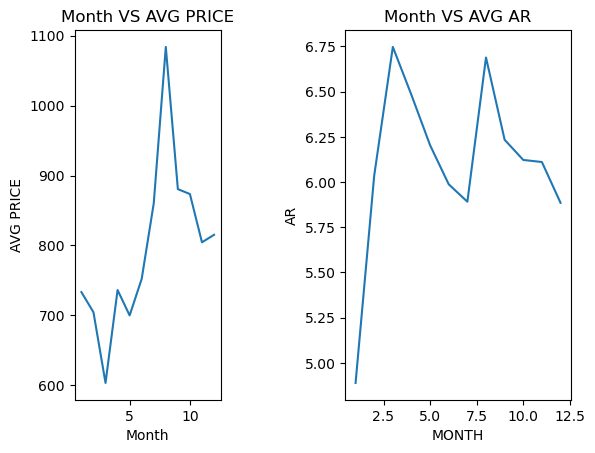

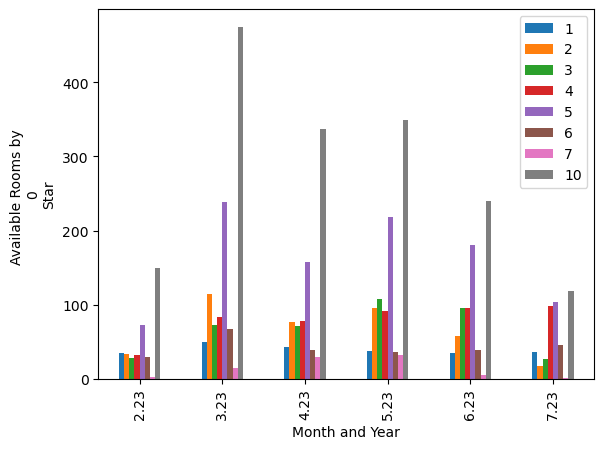

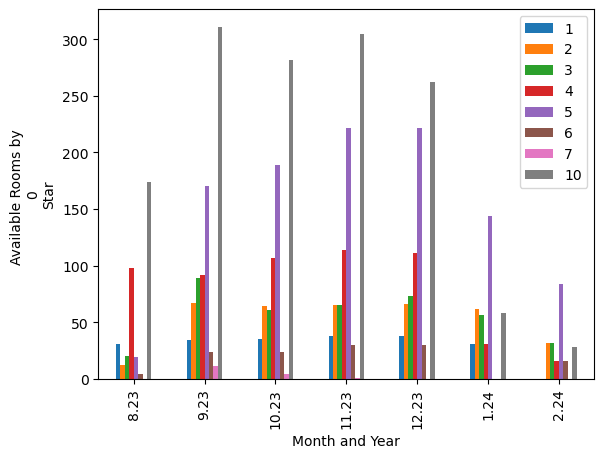

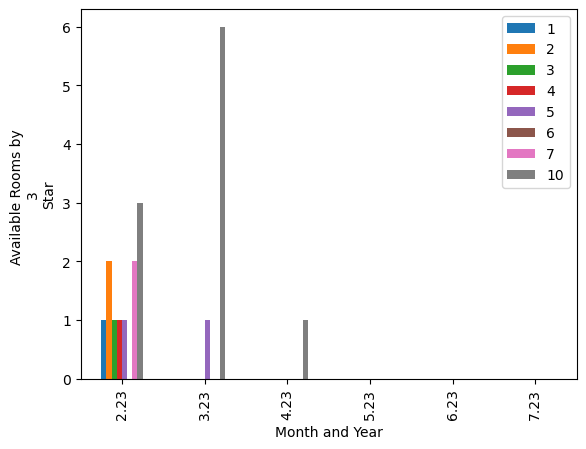

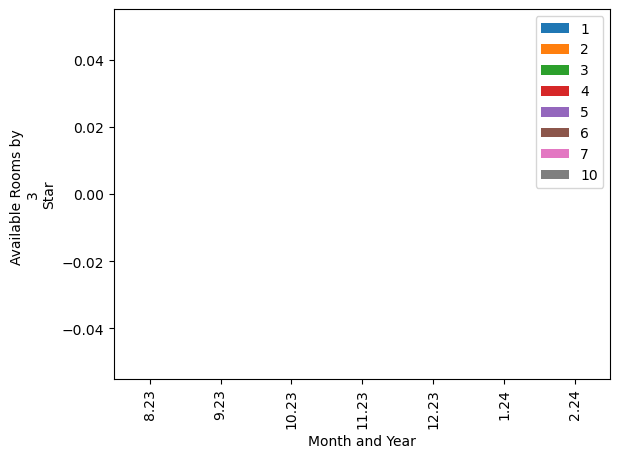

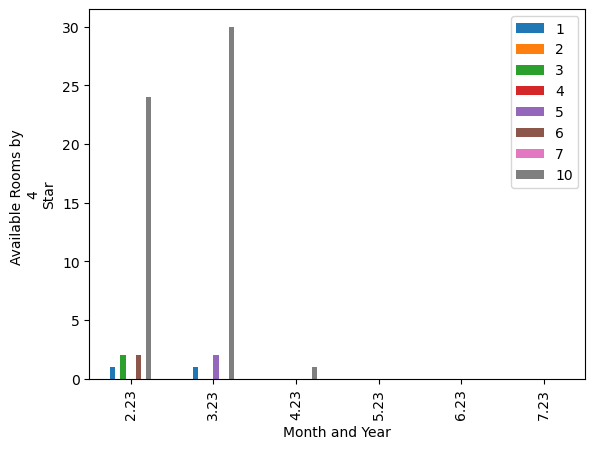

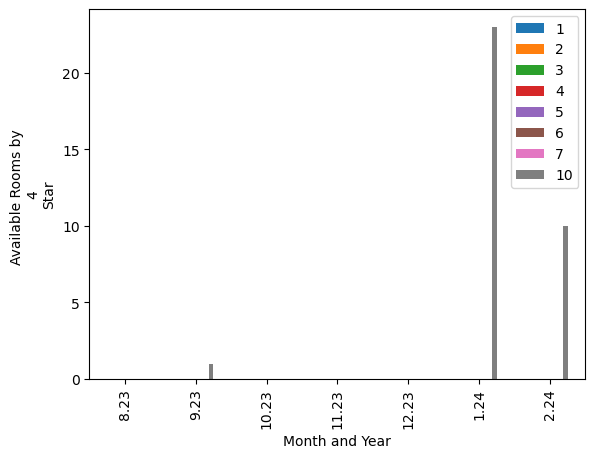

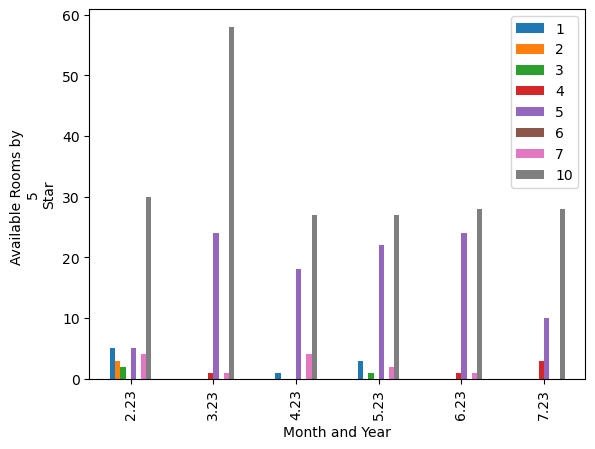

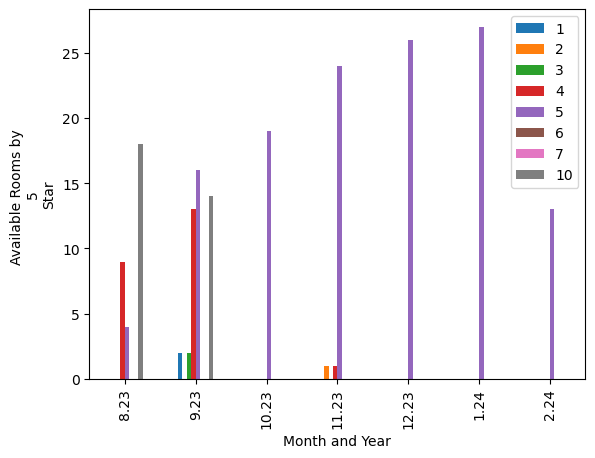

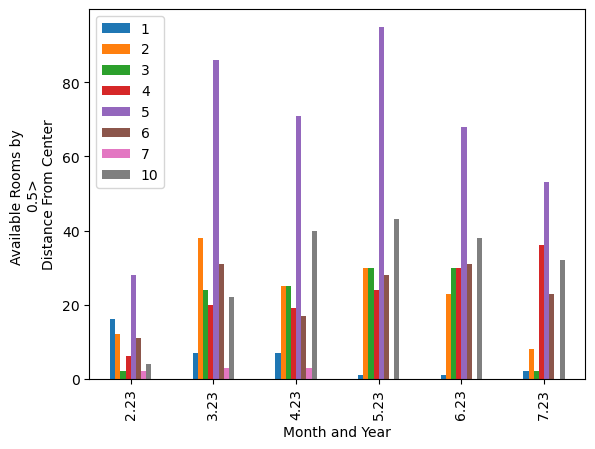

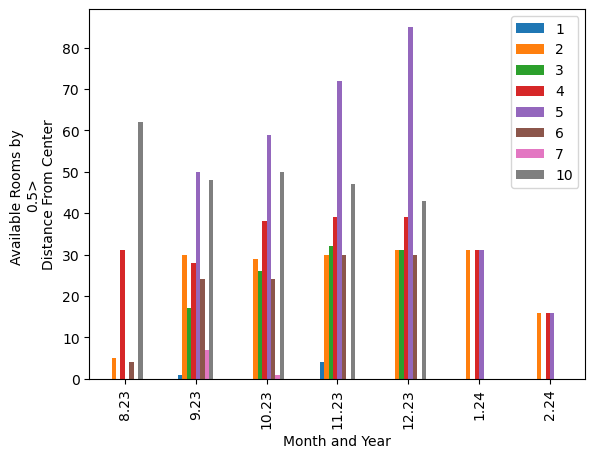

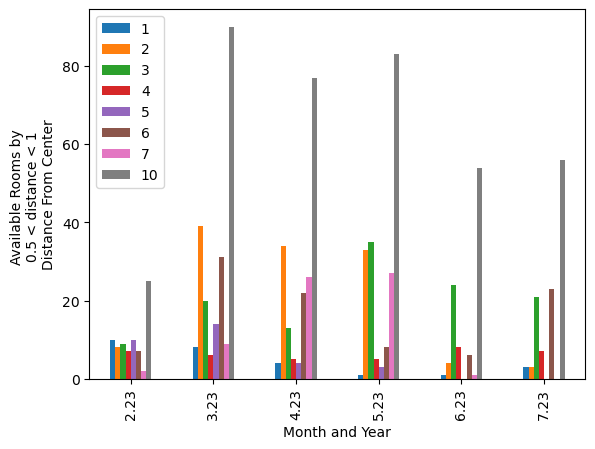

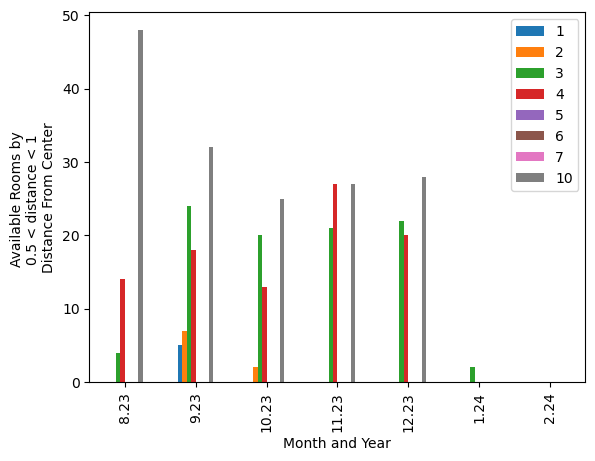

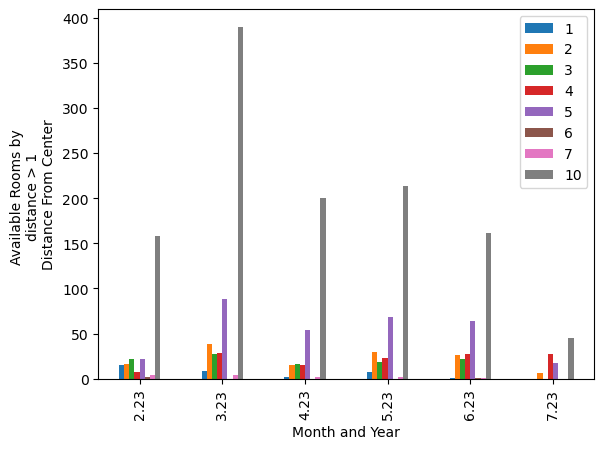

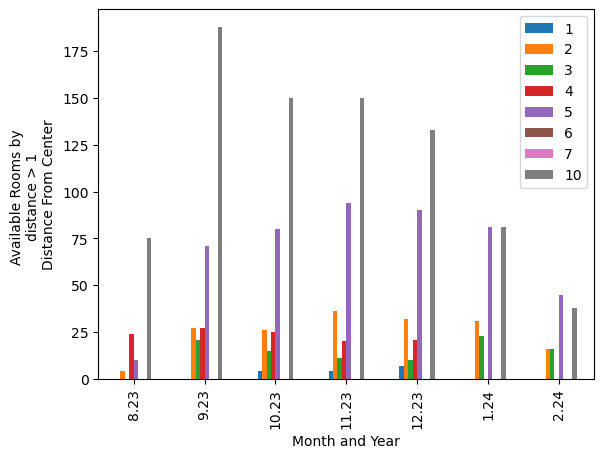

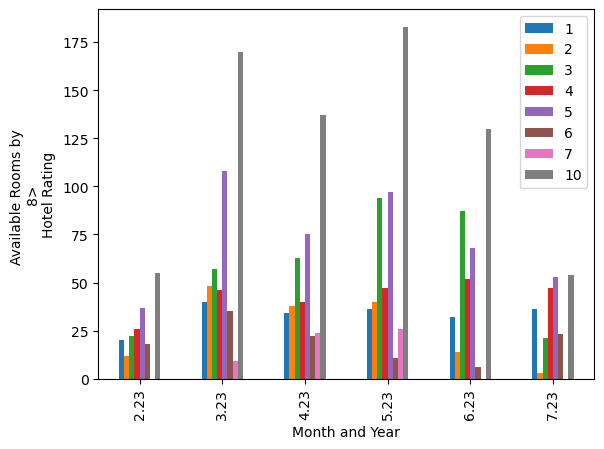

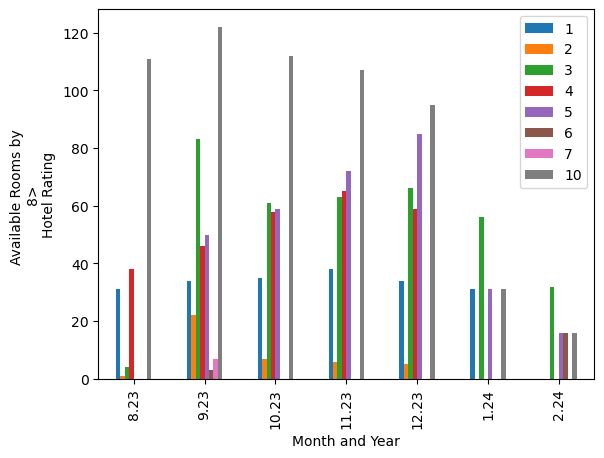

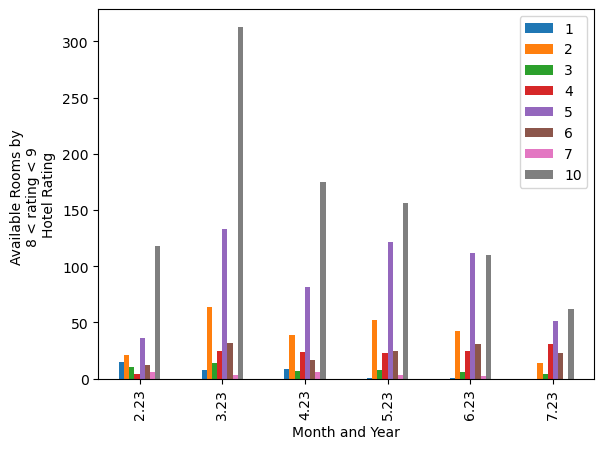

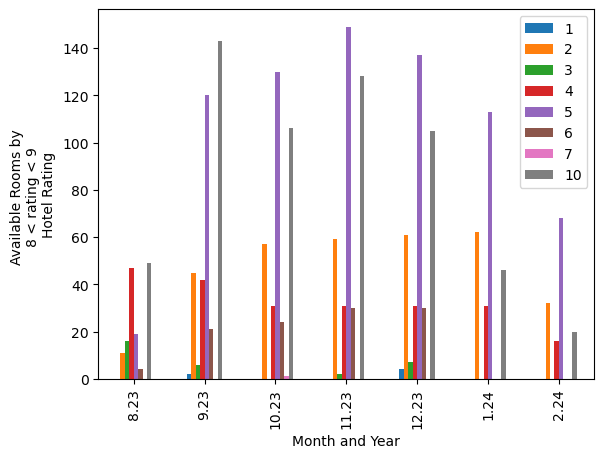

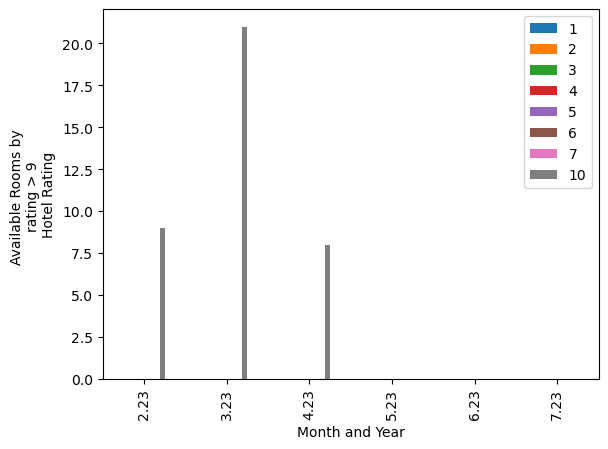

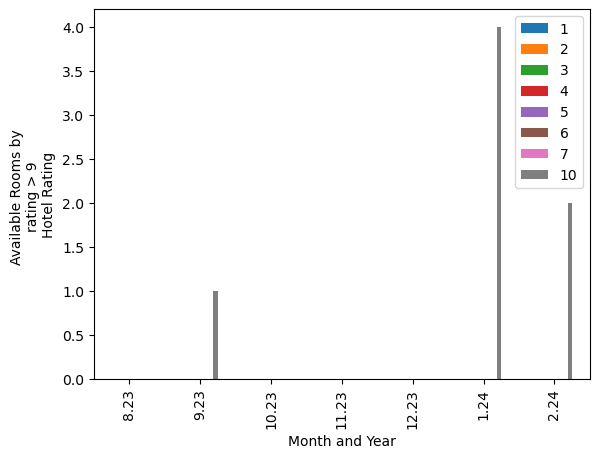

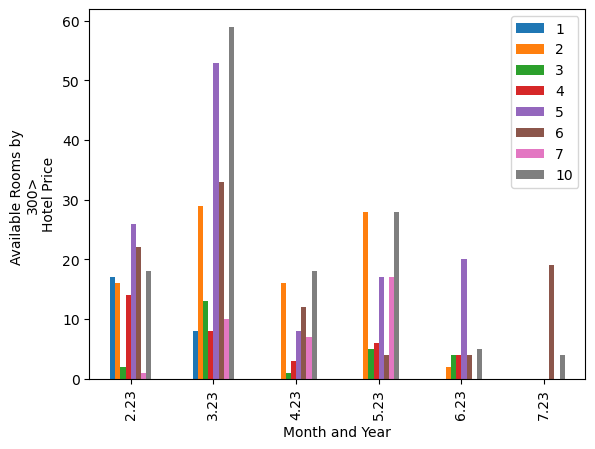

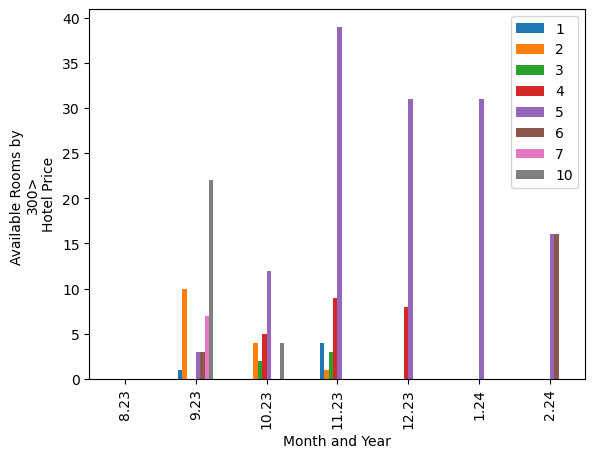

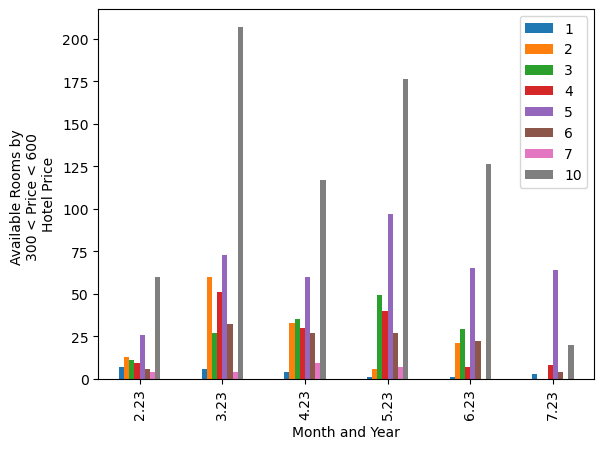

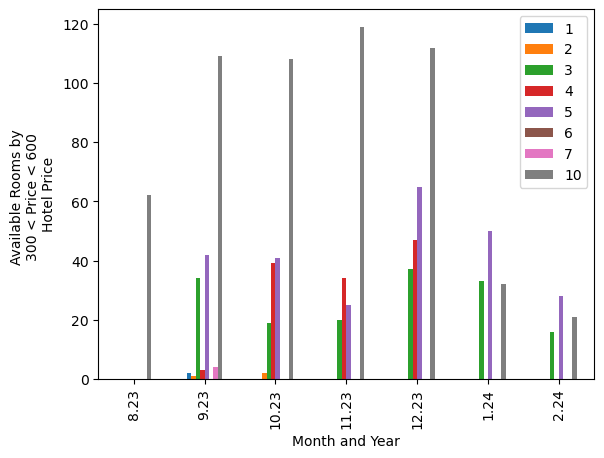

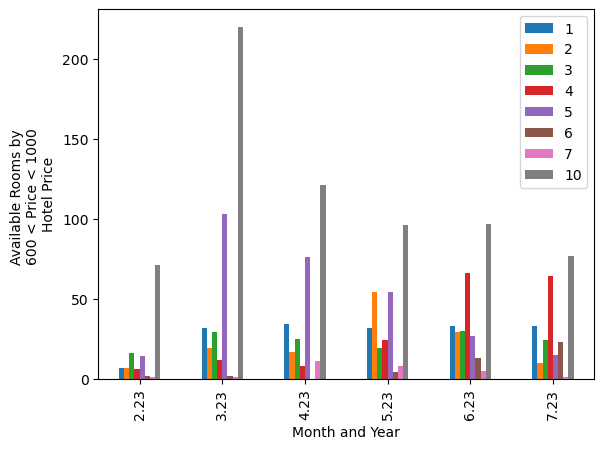

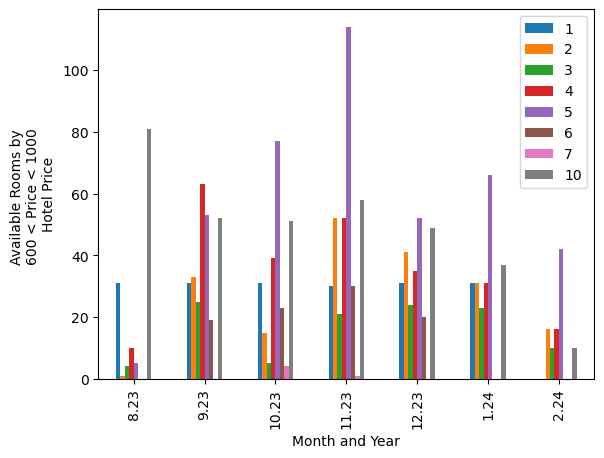

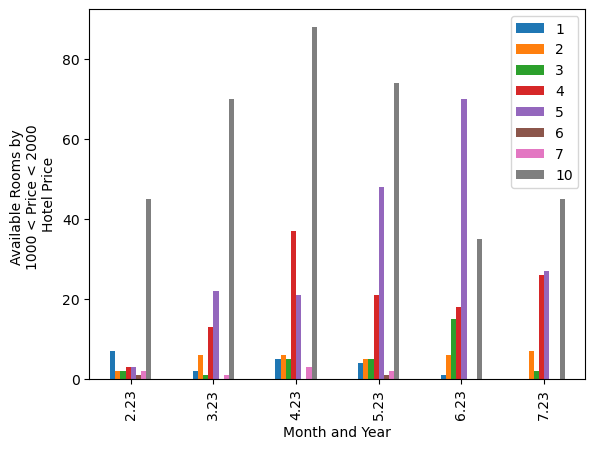

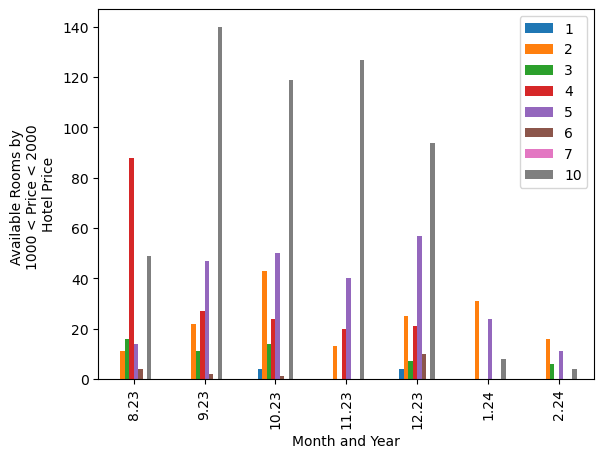

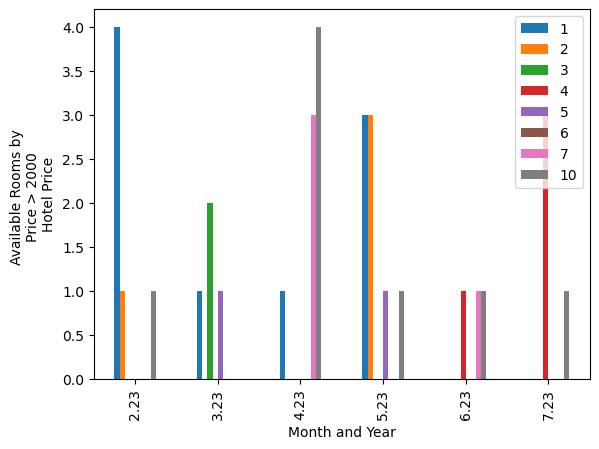

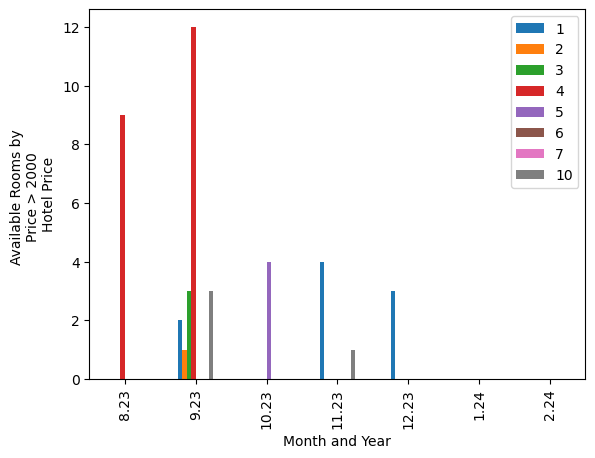

In [19]:
# Our main code - we read our 365 days csv, filter the data we 
# don't need (edge cases like very low hotel ratings or unavailable hotels)
# and then check that the dataframe is ok for starting the EDA.
if __name__ == "__main__":
    df = pd.read_csv('./CsvFolder/Hotels365Day.csv')
    df2 = df.iloc[:, 1:].reset_index(drop=True)
    df2.drop(df2[df2['hotel_rating'] < 3].index, inplace = True)
    df2.drop(df2[df2['number_of_reviews'] < 10].index, inplace = True)
    df2.drop(df2[df2['hotel_price'] < 0].index, inplace = True) # If hotel not available at that date, remove it.
    print("----------Graph Info---------")
    print(df2.info())
    print('\n')
    print("----------Null Cells Check---------")
    print(df2.isna().sum())
    print('\n')
    print("----------Duplicated Check---------")
    print("There are "+str(df.duplicated().sum())+" duplicated rows")
    print('\n')
    # Add the dates' values as columns to our dataframe for the machine learning (day in the week, day, month, year)
    df2 = add_date_columns(df2)
    # Get the 2 graphs of average price and average avilable rooms in relation for each month of the year.
    get_avg_price_vs_available_room_graph_by_month(df2)

    get_graph_for_stars_count(df2)
    get_graph_for_distance_from_center(df2)
    get_graph_for_hotel_rating(df2)
    get_graph_for_hotel_price(df2)    

In [20]:
def split_checkin_to_date_columns(df): 
    day_date_array = [] 
    month_array = [] 
    year_array = [] 
    day_in_a_week_array = []
    # Monday is 0 in the .weekday() command, and Sunday is 6 there, so we convert it to the Israeli way of counting weekdays.
    # i.e - if we get 6 from the .weekday() command, it is Sunday so it should be 1 and not 6.
    week_days_js = {
            0 : 2,
            1 : 3,
            2 : 4,
            3 : 5,
            4 : 6, 
            5 : 7, 
            6 : 1 , 
        }
    
    # Create our lists of values so we can add them as columns to the dataframe afterwards.
    for part in df:
        date = datetime.datetime.strptime(part ,'%Y-%m-%d').date()
        day = date.day
        month = date.month
        year = date.year     
        day_in_week = week_days_js[datetime.date(day=day, month=month, year=year).weekday()]
        day_date_array.append(day)
        month_array.append(month)
        year_array.append(year)
        day_in_a_week_array.append(day_in_week)
          
    return day_in_a_week_array,day_date_array,month_array,year_array

In [21]:
def add_new_column_dates(df,day_in_a_week_array,day_date_array,month_array,year_array):
    df.insert(loc=1, column='day', value=day_in_a_week_array)
    df.insert(loc=2, column='date_day', value=day_date_array)
    df.insert(loc=3, column='month', value=month_array)
    df.insert(loc=4, column='year', value=year_array)
    
    return df2

In [22]:
def create_means_df(df2, month):
    
    ## https://stackoverflow.com/questions/65693824/pandas-get-column-average-for-rows-with-a-certain-value ## 
    hotel_price_mean = df2.groupby("hotel_name")["hotel_price"].mean()
    available_rooms_mean = df2.groupby("hotel_name")["available_rooms"].mean()
    hotel_rating_mean = df2.groupby("hotel_name")["hotel_rating"].mean()
    preferred_hotel_mean = df2.groupby("hotel_name")["preferred_hotel"].mean()
    nnumber_of_reviews_meas = df2.groupby("hotel_name")["number_of_reviews"].mean()
    distance_from_center_mean = df2.groupby("hotel_name")["distance_from_center"].mean()
    stars_count_mean = df2.groupby("hotel_name")["stars_count"].mean()
    new_hotel_mean = df2.groupby("hotel_name")["new_hotel"].mean()
    
    means_df = pd.DataFrame({
                "month": i,
                "hotel_name" : hotel_price_mean.keys(), 
                "available_rooms" : available_rooms_mean.values,
                "hotel_price" : hotel_price_mean.values,
                "hotel_rating" : hotel_rating_mean.values,
                "preferred_hotel" : preferred_hotel_mean.values, 
                "number_of_reviews" : nnumber_of_reviews_meas.values,
                "distance_from_center" : stars_count_mean.values, 
                "stars_count" : stars_count_mean.values,
                "new_hotel" : new_hotel_mean.values,
                ### Add 'day' as well !! And add to the Machine Learning too. ###
                })  
    return means_df

In [23]:
def return_r_squared(df, month):
    print("Number of Rows: " + str(len(df)))
    print("Free Available Hotels: " + str(len(df[df['available_rooms'] == 10])))
    df.drop(df[df['available_rooms'] == 10].index, inplace = True)
    df = create_means_df(df, month)
    x = df[[
    'month',    
    'stars_count',
    'hotel_price',
    'number_of_reviews',
    'distance_from_center',
    'hotel_rating',
    'new_hotel',
    'preferred_hotel',    
     ]]

    # https://labs.vocareum.com/main/main.php?m=editor&asnid=537364&stepid=537365&hideNavBar=1 + https://towardsdatascience.com/machine-learning-simple-linear-regression-with-python-f04ecfdadc13 
    y = df['available_rooms']

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    prediction = lr.predict(X_test)

    pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': prediction}).head(25)
    
    # Slope is the slope (shipua) of our linear line,
    # While the intercept is the crossing line (nekudat hituh) between 
    # the line and the Y line (available_rooms) - this information doesn't 
    # help us too much in this case.
    print("Slope:",lr.coef_)
    print("Intercept:",lr.intercept_)
    
    # R2 to determine how good is the model for predicting.
    print("R2:",lr.score(x,y))

    return

In [24]:
if __name__ == "__main__":
    df = pd.read_csv('./CsvFolder/Hotels365Day.csv')
    # We sort the values by check-in dates, then we reset the indexes and create a dates column to split it 
    # into 4 columns to add to our dataframe for better machine learning prediction.
    df.sort_values('check_in', inplace=True)
    df2 = df.iloc[:, 1:].reset_index(drop=True)
    dates_columns = df2['check_in']

    day_in_a_week_array,day_date_array,month_array,year_array = split_checkin_to_date_columns(dates_columns)
    
    ## This is the new data frame after splitting the date to 4 columns 
    df2 = add_new_column_dates(df2,day_in_a_week_array,day_date_array,month_array,year_array)
    
    # Remove hotels with values that are on edge (Usually new hotels which may ruin our prediction) like in our EDA
    df2.drop(df2[df2['hotel_rating'] < 3].index, inplace = True)
    df2.drop(df2[df2['number_of_reviews'] < 10].index, inplace = True)
    df2.drop(df2[df2['hotel_price'] < 0].index, inplace = True) # If hotel not available at the same date, remove it.'ג'ג
    
    # Get the linear regression model information for each month in the next year.
    for i in range(1,13):
        print("Month Number "+ str(i))    
        return_r_squared(df2[df2['month'] == i], i)
        print('-----------------\n\n')

Month Number 1
Number of Rows: 432
Free Available Hotels: 81
Slope: [ 0.00000000e+00  1.20217124e-01 -4.26676524e-03 -3.31082431e-04
  1.20217124e-01  1.35011886e+00 -4.59438632e-01 -5.77870614e-01]
Intercept: -3.0707310376020125
R2: 0.8275734801469808
-----------------


Month Number 2
Number of Rows: 703
Free Available Hotels: 245
Slope: [ 0.00000000e+00 -1.82143473e-03 -5.24789068e-04  3.79870971e-04
 -1.82143473e-03 -3.28681872e-02 -7.86241117e-01 -6.40532922e-01]
Intercept: 4.390827362437801
R2: 0.2804774932192792
-----------------


Month Number 3
Number of Rows: 1240
Free Available Hotels: 569
Slope: [ 0.00000000e+00  5.30692247e-02 -1.02546835e-03 -1.54893407e-04
  5.30692247e-02  4.52813528e-01 -4.18147519e-01 -9.36438174e-01]
Intercept: 1.830815444913516
R2: 0.1737166523183593
-----------------


Month Number 4
Number of Rows: 883
Free Available Hotels: 366
Slope: [ 0.00000000e+00  6.72820453e-02 -2.22149698e-03 -5.63717845e-04
  6.72820453e-02  9.26788231e-01  5.04452910e-01

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13536\2149660317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['available_rooms'] == 10].index, inplace = True)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13536\2149660317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['available_rooms'] == 10].index, inplace = True)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13536\2149660317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan